<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%83%81%EC%B6%94%EC%9D%98_%EC%83%9D%EC%9C%A1_%ED%99%98%EA%B2%BD_%EC%83%9D%EC%84%B1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

상추의 생육 환경 생성 AI 경진대회

https://dacon.io/competitions/official/236033/overview/description

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from tqdm import tqdm
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers

# data(cat)

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip'

In [ ]:
train_01 = pd.read_csv('/content/train_input/CASE_01.csv')

In [ ]:
train_01.columns

Index(['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

In [ ]:
train_li = sorted(glob.glob('/content/train_input/*'))
test_li = sorted(glob.glob('/content/test_input/*'))

시간당 내부 평균온도: 4도~40도

시간당 내부 평균습도: 0% ~ 100%

시간당 내부 평균 co2 농도 : 0ppm ~ 1200 ppm

시간당 평균 EC : 0 ~ 8

시간당 분무량 : 0 ~ 3000 / 일간 누적 분무량 0 ~ 72,000

시간당 백색광량 : 0 ~ 120,000 / 일간 누적 백색광량 0 ~ 2,880,000

시간당 적색광량 : 0 ~ 120,000 / 일간 누적 적색광량 0 ~ 2,880,000 

시간당 청색광량 : 0 ~ 120,000 / 일간 누적 청색광량 0 ~ 2,880,000

시간당 총광량 : 0 ~ 120,000 / 일간 누적 총광량 0 ~ 2,880,000

In [ ]:
for i in train_li + test_li:
    df = pd.read_csv(i)
    df['내부온도관측치'] = df['내부온도관측치'].clip(4,40)
    df['내부습도관측치'] = df['내부습도관측치'].clip(0,100)
    df['co2관측치']  = df['co2관측치'].clip(0,1200)
    df['ec관측치']  = df['ec관측치'].clip(0,8)
    df['시간당분무량']  = df['시간당분무량'].clip(0,3000)
    df['일간누적분무량']  = df['일간누적분무량'].clip(0,72000)
    df['시간당백색광량']  = df['시간당백색광량'].clip(0,120000)
    df['일간누적백색광량']  = df['일간누적백색광량'].clip(0,2880000)
    df['시간당적색광량']  = df['시간당적색광량'].clip(0,120000)
    df['일간누적적색광량']  = df['일간누적적색광량'].clip(0,2880000)
    df['시간당청색광량']  = df['시간당청색광량'].clip(0,120000)
    df['일간누적청색광량']  = df['일간누적청색광량'].clip(0,2880000)
    df['시간당총광량']  = df['시간당총광량'].clip(0,120000)
    df['일간누적총광량']  = df['일간누적총광량'].clip(0,2880000)
    df.to_csv(i, index=False)

In [ ]:
li_mean = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량']
li_max = ['일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
li_min = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치']
li_max_2 = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치']

In [ ]:
def make_data(file):
    df = pd.read_csv(file)
    date = list(set(df['DAT'].values))
    case = {}

    for i in li_mean:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].mean())
        case[i] = va

    for i in li_max:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].max())
        case[i] = va

    for i in li_max_2:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].max())
        case[i+'max'] = va

    for i in li_min:
        va = []
        for j in date:
            tt = df[df['DAT'] == j]
            va.append(tt[i].min())
        case[i+'min'] = va

    mdf = pd.DataFrame(case)
    return mdf

for i, j in enumerate(train_li):
    if i == 0:
        train_x = make_data(j)
    else:
        train_some = make_data(j)
        train_x = pd.concat([train_x, train_some], axis=0)
train_x.reset_index(drop=True, inplace=True)

for i, j in enumerate(test_li):
    if i == 0:
        test_x = make_data(j)
    else:
        test_some = make_data(j)
        test_x = pd.concat([test_x, test_some], axis=0)
test_x.reset_index(drop=True, inplace=True)
test_x

,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,시간당총광량,일간누적분무량,...,일간누적청색광량,일간누적총광량,내부온도관측치max,내부습도관측치max,co2관측치max,ec관측치max,내부온도관측치min,내부습도관측치min,co2관측치min,ec관측치min
0,27.489730,61.372104,465.722917,1.037389,510.255417,8728.198258,0.00000,0.000000,8728.198258,12246.13,...,0.000,209476.7582,28.983333,69.930000,476.666667,1.041927,25.871666,58.303333,458.616667,1.028971
1,28.668803,63.148023,463.661311,1.034501,383.964167,8729.874229,0.00000,0.000000,8729.874229,9215.14,...,0.000,209516.9815,30.481667,71.205000,474.666667,1.043185,26.900000,59.256667,453.783333,1.026865
2,28.407405,61.045223,488.883086,1.033113,496.323750,8734.386458,0.00000,0.000000,8734.386458,11911.77,...,0.000,209625.2750,29.378333,64.435001,500.950000,1.036868,27.281666,58.758333,480.100000,1.030345
3,28.163750,64.356319,494.394444,1.033793,512.398750,8732.839408,0.00000,0.000000,8732.839408,12297.57,...,0.000,209588.1458,29.771666,69.993332,512.266667,1.039821,26.935000,59.966667,479.466667,1.028521
4,27.302220,66.829097,528.349306,1.038796,369.764583,8734.515379,0.00000,0.000000,8734.515379,8874.35,...,0.000,209628.3691,29.416666,73.918333,578.133333,1.048193,26.353333,57.998333,498.183333,1.031513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,25.884889,56.707123,460.703472,0.244860,133.285000,6111.878867,927.92910,436.270250,7476.078217,3198.84,...,10470.486,179425.8772,27.348333,58.360000,700.800000,0.890030,23.715000,53.865000,388.750000,0.000000
136,25.439344,56.979188,438.658477,0.912453,135.428333,6093.056425,924.68845,434.834292,7452.579167,3250.28,...,10436.023,178861.9000,27.076667,58.475000,477.450000,0.922210,23.718333,56.221667,389.733333,0.895684
137,25.041662,57.322359,443.938089,0.915924,113.892500,6110.331817,927.03275,435.878625,7473.243192,2733.42,...,10461.087,179357.8366,26.696667,58.848334,556.383333,0.937101,23.531667,56.331667,365.050000,0.902878
138,25.617847,57.048055,447.692361,0.918316,124.392500,6107.495558,927.23960,435.748083,7470.483242,2985.42,...,10457.954,179291.5978,29.650000,58.156667,609.100000,0.928885,23.526667,55.303333,387.200000,0.879491


In [ ]:
li_diff = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량',
           '일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']

In [ ]:
for i in li_diff:
    train_x[i+'diff'] = train_x[i].diff()
    test_x[i+'diff'] = test_x[i].diff()
    train_x[i+'diff2'] = train_x[i].diff(periods=2)
    test_x[i+'diff2'] = test_x[i].diff(periods=2)
    train_x[i+'diff3'] = train_x[i].diff(periods=3)
    test_x[i+'diff3'] = test_x[i].diff(periods=3)
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [ ]:
train_ta = sorted(glob.glob('/content/train_target/*'))
for i, j in enumerate(train_ta):
    if i == 0:
        train_y = pd.read_csv(j)
    else:
        train_y_some = pd.read_csv(j)
        train_y = pd.concat([train_y, train_y_some], axis=0)
train_y.reset_index(drop=True, inplace=True)

In [ ]:
test_ta = sorted(glob.glob('/content/test_target/*'))
for i, j in enumerate(test_ta):
    if i == 0:
        test_y = pd.read_csv(j)
    else:
        test_y_some = pd.read_csv(j)
        test_y = pd.concat([test_y, test_y_some], axis=0)
test_y.reset_index(drop=True, inplace=True)

In [ ]:
train_all = pd.concat([train_x, train_y], axis=1)
test_all = pd.concat([test_x, test_y], axis=1)

In [ ]:
test_x = test_all.copy()
test_y = test_x.pop('predicted_weight_g')

In [ ]:
train_x.columns

Index(['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '시간당백색광량', '시간당적색광량',
       '시간당청색광량', '시간당총광량', '일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량',
       '일간누적총광량', '내부온도관측치max', '내부습도관측치max', 'co2관측치max', 'ec관측치max',
       '내부온도관측치min', '내부습도관측치min', 'co2관측치min', 'ec관측치min', '내부온도관측치diff',
       '내부온도관측치diff2', '내부온도관측치diff3', '내부습도관측치diff', '내부습도관측치diff2',
       '내부습도관측치diff3', 'co2관측치diff', 'co2관측치diff2', 'co2관측치diff3', 'ec관측치diff',
       'ec관측치diff2', 'ec관측치diff3', '시간당분무량diff', '시간당분무량diff2', '시간당분무량diff3',
       '시간당백색광량diff', '시간당백색광량diff2', '시간당백색광량diff3', '시간당적색광량diff',
       '시간당적색광량diff2', '시간당적색광량diff3', '시간당청색광량diff', '시간당청색광량diff2',
       '시간당청색광량diff3', '시간당총광량diff', '시간당총광량diff2', '시간당총광량diff3',
       '일간누적분무량diff', '일간누적분무량diff2', '일간누적분무량diff3', '일간누적백색광량diff',
       '일간누적백색광량diff2', '일간누적백색광량diff3', '일간누적적색광량diff', '일간누적적색광량diff2',
       '일간누적적색광량diff3', '일간누적청색광량diff', '일간누적청색광량diff2', '일간누적청색광량diff3',
       '일간누적총광량diff', '일간누적총광량diff2', '일간누적총광량

# cat

In [ ]:
train_t = train_all[:-28]
train_v = train_all[-28:]

In [ ]:
train_x = train_t.copy()
train_y = train_x.pop('predicted_weight_g')
val_x = train_v.copy()
val_y = val_x.pop('predicted_weight_g')

In [ ]:
lr = LinearRegression()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
models = [lr, knr, rfr, xgb, lgbm, cat]
for i in models:
    model = i.fit(train_x, train_y)
    sc = round(model.score(train_x, train_y), 2)
    pre = model.predict(val_x)
    rmse = round(mean_squared_error(val_y, pre, squared=False), 2)
    print(f'model : {i.__class__.__name__}, sc : {sc}, rmse : {rmse}')

model : LinearRegression, sc : 0.75, rmse : 14.65
model : KNeighborsRegressor, sc : 0.61, rmse : 9.14
model : RandomForestRegressor, sc : 0.99, rmse : 4.99
[03:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model : XGBRegressor, sc : 0.99, rmse : 6.36
model : LGBMRegressor, sc : 1.0, rmse : 6.81
model : CatBoostRegressor, sc : 1.0, rmse : 3.79


In [ ]:
lr = LinearRegression()
knr = KNeighborsRegressor()
rfr = RandomForestRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()
cat = CatBoostRegressor(verbose=0)
models = [lr, knr, rfr, xgb, lgbm, cat]
for i in models:
    model = i.fit(train_x, train_y)
    sc = round(model.score(train_x, train_y), 2)
    pre = model.predict(val_x)
    rmse = round(mean_squared_error(val_y, pre, squared=False), 2)
    print(f'model : {i.__class__.__name__}, sc : {sc}, rmse : {rmse}')

model : LinearRegression, sc : 0.77, rmse : 12.62
model : KNeighborsRegressor, sc : 0.62, rmse : 8.31
model : RandomForestRegressor, sc : 0.99, rmse : 4.76
[03:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model : XGBRegressor, sc : 0.99, rmse : 6.64
model : LGBMRegressor, sc : 1.0, rmse : 6.91
model : CatBoostRegressor, sc : 1.0, rmse : 3.48


In [ ]:
train_x = train_all.copy()
train_y = train_x.pop('predicted_weight_g')

In [ ]:
cat = CatBoostRegressor(verbose=0)
params = {'learning_rate' : [0.2, 0.3, 0.4], 'n_estimators' : [100, 120, 80], 'max_depth' : [5, 7, 6]}
gcv = GridSearchCV(cat, params, cv=5, scoring='neg_mean_squared_error')
model = gcv.fit(train_x, train_y)

In [ ]:
print(model.best_score_)
print(model.best_params_)

-474.8256596580048
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
print(model.best_score_)
print(model.best_params_)

-461.49864417642283
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
print(model.best_score_)
print(model.best_params_)

-461.49864417642283
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
cat = CatBoostRegressor(verbose=0)
model = cat.fit(train_x, train_y)
pre = model.predict(test_x)

#  data(CNN)

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip'
train_li = sorted(glob.glob('/content/train_input/*'))
test_li = sorted(glob.glob('/content/test_input/*'))
for i in train_li + test_li:
    df = pd.read_csv(i)
    df['내부온도관측치'] = df['내부온도관측치'].clip(4,40)
    df['내부습도관측치'] = df['내부습도관측치'].clip(0,100)
    df['co2관측치']  = df['co2관측치'].clip(0,1200)
    df['ec관측치']  = df['ec관측치'].clip(0,8)
    df['시간당분무량']  = df['시간당분무량'].clip(0,3000)
    df['일간누적분무량']  = df['일간누적분무량'].clip(0,72000)
    df['시간당백색광량']  = df['시간당백색광량'].clip(0,120000)
    df['일간누적백색광량']  = df['일간누적백색광량'].clip(0,2880000)
    df['시간당적색광량']  = df['시간당적색광량'].clip(0,120000)
    df['일간누적적색광량']  = df['일간누적적색광량'].clip(0,2880000)
    df['시간당청색광량']  = df['시간당청색광량'].clip(0,120000)
    df['일간누적청색광량']  = df['일간누적청색광량'].clip(0,2880000)
    df['시간당총광량']  = df['시간당총광량'].clip(0,120000)
    df['일간누적총광량']  = df['일간누적총광량'].clip(0,2880000)
    df['obs_time'] = df['obs_time'].str[:2].apply(int)
    df.to_csv(i, index=False)

Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip
replace sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.zip   
  inflating: test_input/TEST_01.csv  
  inflating: test_input/TEST_02.csv  
  inflating: test_input/TEST_03.csv  
  inflating: test_input/TEST_04.csv  
  inflating: test_input/TEST_05.csv  
  inflating: test_target/TEST_01.csv  
  inflating: test_target/TEST_02.csv  
  inflating: test_target/TEST_03.csv  
  inflating: test_target/TEST_04.csv  
  inflating: test_target/TEST_05.csv  
  inflating: train_input/CASE_01.csv  
  inflating: train_input/CASE_02.csv  
  inflating: train_input/CASE_03.csv  
  inflating: train_input/CASE_04.csv  
  inflating: train_input/CASE_05.csv  
  inflating: train_input/CASE_06.csv  
  inflating: train_input/CASE_07.csv  
  inflating: train_input/CASE_08.csv  
  inflating: train_input/CASE_09.csv  
  inflating: train_input/CASE_10.csv  
  inflating: train_input/CASE_11.csv  
 

In [ ]:
for i, j in enumerate(train_li):
    if i == 0:
        train_x = pd.read_csv(j)
    else:
        train_x_some = pd.read_csv(j)
        train_x = pd.concat([train_x, train_x_some], axis=0)
train_x.reset_index(drop=True, inplace=True)       
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   obs_time  18816 non-null  int64  
 2   내부온도관측치   18816 non-null  float64
 3   내부습도관측치   18816 non-null  float64
 4   co2관측치    18816 non-null  float64
 5   ec관측치     18816 non-null  float64
 6   시간당분무량    18816 non-null  float64
 7   일간누적분무량   18816 non-null  float64
 8   시간당백색광량   18816 non-null  float64
 9   일간누적백색광량  18816 non-null  float64
 10  시간당적색광량   18816 non-null  float64
 11  일간누적적색광량  18816 non-null  float64
 12  시간당청색광량   18816 non-null  float64
 13  일간누적청색광량  18816 non-null  float64
 14  시간당총광량    18816 non-null  float64
 15  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(2)
memory usage: 2.3 MB


In [ ]:
train_xx = train_x.copy()
_ = train_xx.pop('obs_time')

In [ ]:
train_xx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18816 entries, 0 to 18815
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DAT       18816 non-null  int64  
 1   내부온도관측치   18816 non-null  float64
 2   내부습도관측치   18816 non-null  float64
 3   co2관측치    18816 non-null  float64
 4   ec관측치     18816 non-null  float64
 5   시간당분무량    18816 non-null  float64
 6   일간누적분무량   18816 non-null  float64
 7   시간당백색광량   18816 non-null  float64
 8   일간누적백색광량  18816 non-null  float64
 9   시간당적색광량   18816 non-null  float64
 10  일간누적적색광량  18816 non-null  float64
 11  시간당청색광량   18816 non-null  float64
 12  일간누적청색광량  18816 non-null  float64
 13  시간당총광량    18816 non-null  float64
 14  일간누적총광량   18816 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 2.2 MB


In [ ]:
train_xx.iloc[671]

DAT             27.000000
내부온도관측치         27.868333
내부습도관측치         82.453333
co2관측치         588.616667
ec관측치            0.000000
시간당분무량           0.000000
일간누적분무량       3890.540000
시간당백색광량          0.000000
일간누적백색광량    255263.250000
시간당적색광량          0.000000
일간누적적색광량     13652.100000
시간당청색광량          0.000000
일간누적청색광량         0.000000
시간당총광량           0.000000
일간누적총광량     268915.350000
Name: 671, dtype: float64

In [ ]:
mms = MinMaxScaler()
for i in train_xx.columns:
    train_xx[i] = mms.fit_transform(train_xx[[i]])

In [ ]:
train_image = train_xx.values.reshape(-1,24,15,1)
train_image.shape

(784, 24, 15, 1)

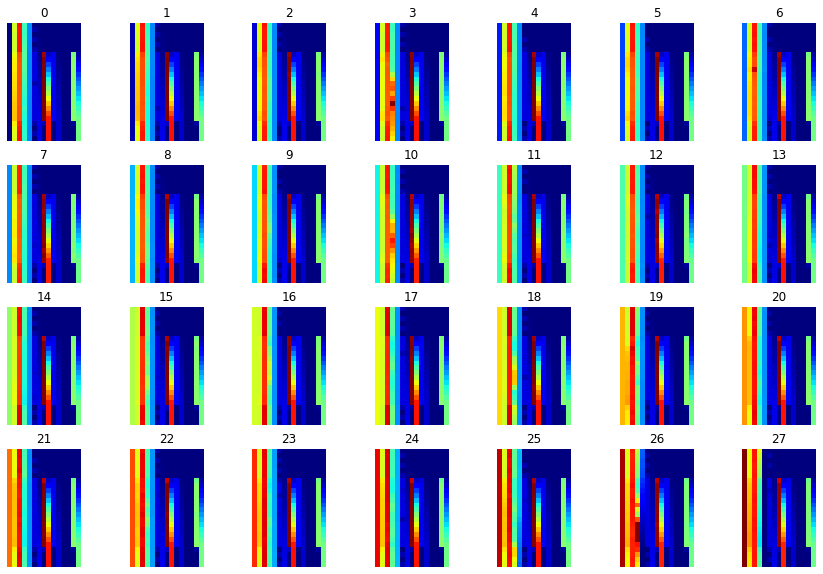

In [ ]:
plt.figure(figsize=(15,10))
for i in range(28):
    plt.subplot(4,7,i+1)
    plt.title(i)
    plt.imshow(train_image[i][:,:,0], cmap='jet')
    plt.axis(False)
plt.show()

In [ ]:
train_ta = sorted(glob.glob('/content/train_target/*'))
for i, j in enumerate(train_ta):
    if i == 0:
        train_y = pd.read_csv(j)
    else:
        train_y_some = pd.read_csv(j)
        train_y = pd.concat([train_y, train_y_some], axis=0)
train_y.reset_index(drop=True, inplace=True)

In [ ]:
train_y = train_y['predicted_weight_g']
train_y.shape

(784,)

# CNN

In [ ]:
def make_model():
    inputs = layers.Input(shape=(24,15,1))
    x = layers.Conv2D(16,3,padding='same',activation='relu')(inputs)
    x = layers.Conv2D(16,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    # x = layers.MaxPool2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = make_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24, 15, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 15, 16)        160       
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 15, 16)        2320      
                                                                 
 batch_normalization_9 (Batc  (None, 24, 15, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 15, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 15, 32)        9248      
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
eary_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2)

In [ ]:
his = model.fit(train_image, train_y, epochs=100, validation_split=0.1, callbacks=[eary_stop, lr_rate])

Epoch 1/100
23/23 [==============================] - 5s 190ms/step - loss: 2861.6233 - val_loss: 1270.2950 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 4s 183ms/step - loss: 1724.2657 - val_loss: 1188.7721 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 4s 182ms/step - loss: 660.3204 - val_loss: 1122.0752 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 4s 182ms/step - loss: 330.5437 - val_loss: 1092.8198 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 4s 182ms/step - loss: 259.3437 - val_loss: 1063.2960 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 4s 183ms/step - loss: 253.2687 - val_loss: 982.3447 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 4s 182ms/step - loss: 344.7022 - val_loss: 1038.4528 - lr: 0.0010
Epoch 8/100
23/23 [==============================] - 4s 183ms/step - loss: 181.6578 - val_loss: 965.4042 - lr: 0.0010
Epoch 9/100
23/23 [=============================

# lstm

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip'
train_li = sorted(glob.glob('/content/train_input/*'))
test_li = sorted(glob.glob('/content/test_input/*'))
for i in train_li + test_li:
    df = pd.read_csv(i)
    df['내부온도관측치'] = df['내부온도관측치'].clip(4,40)
    df['내부습도관측치'] = df['내부습도관측치'].clip(0,100)
    df['co2관측치']  = df['co2관측치'].clip(0,1200)
    df['ec관측치']  = df['ec관측치'].clip(0,8)
    df['시간당분무량']  = df['시간당분무량'].clip(0,3000)
    df['일간누적분무량']  = df['일간누적분무량'].clip(0,72000)
    df['시간당백색광량']  = df['시간당백색광량'].clip(0,120000)
    df['일간누적백색광량']  = df['일간누적백색광량'].clip(0,2880000)
    df['시간당적색광량']  = df['시간당적색광량'].clip(0,120000)
    df['일간누적적색광량']  = df['일간누적적색광량'].clip(0,2880000)
    df['시간당청색광량']  = df['시간당청색광량'].clip(0,120000)
    df['일간누적청색광량']  = df['일간누적청색광량'].clip(0,2880000)
    df['시간당총광량']  = df['시간당총광량'].clip(0,120000)
    df['일간누적총광량']  = df['일간누적총광량'].clip(0,2880000)
    df['obs_time'] = df['obs_time'].str[:2].apply(int)
    df.to_csv(i, index=False)

train_ta_li = sorted(glob.glob('/content/train_target/*'))
test_ta_li = sorted(glob.glob('/content/test_target/*'))

Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/상추/open (1).zip
replace sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.zip   
  inflating: test_input/TEST_01.csv  
  inflating: test_input/TEST_02.csv  
  inflating: test_input/TEST_03.csv  
  inflating: test_input/TEST_04.csv  
  inflating: test_input/TEST_05.csv  
  inflating: test_target/TEST_01.csv  
  inflating: test_target/TEST_02.csv  
  inflating: test_target/TEST_03.csv  
  inflating: test_target/TEST_04.csv  
  inflating: test_target/TEST_05.csv  
  inflating: train_input/CASE_01.csv  
  inflating: train_input/CASE_02.csv  
  inflating: train_input/CASE_03.csv  
  inflating: train_input/CASE_04.csv  
  inflating: train_input/CASE_05.csv  
  inflating: train_input/CASE_06.csv  
  inflating: train_input/CASE_07.csv  
  inflating: train_input/CASE_08.csv  
  inflating: train_input/CASE_09.csv  
  inflating: train_input/CASE_10.csv  
  inflating: train_input/CASE_11.csv  
 

In [ ]:
mms = MinMaxScaler()
class data_loder(tf.keras.utils.Sequence):
    def __init__(self, x_path, y_path=None, batch_size=16, shuffle=False, test=False):
        self.x_path = x_path
        self.y_path = y_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.test = test

        self.x_data_all = []
        self.y_data_all = []
        for x_file, y_file in zip(self.x_path, self.y_path):
            x_df = pd.read_csv(x_file)
            x_df = x_df.drop('obs_time', axis=1)
            for i in x_df.columns:
                x_df[i] = mms.fit_transform(x_df[[i]])
            x_df = x_df.values
            y_df = pd.read_csv(y_file)
            for i in y_df['predicted_weight_g'].values:
                self.y_data_all.append(i)
            for i in range(len(y_df)):
                self.x_data_all.append(x_df[i * 24 : (i+1) * 24])
        
        self.on_epoch_end()

    def __len__(self):
        return (len(self.y_data_all) // self.batch_size)+1
    
    def __getitem__(self, idx):
        data_no = self.data_no[idx * self.batch_size : (idx+1) * self.batch_size]
        x_data = [self.x_data_all[i] for i in data_no]
        y_data = [self.y_data_all[i] for i in data_no]
        if self.test:
            return np.array(x_data)
        else:
            return np.array(x_data), np.array(y_data)

    def on_epoch_end(self):
        self.data_no = np.arange(len(self.y_data_all))
        if self.shuffle:
            np.random.shuffle(self.data_no)

In [ ]:
def make_model():
    inputs = layers.Input(shape=(24,15))
    x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(inputs)
    x = layers.Bidirectional(layers.LSTM(512))(x)
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

========== 1fold ==========
Epoch 1/100
44/44 [==============================] - 52s 1s/step - loss: 25.0170 - val_loss: 12.6449 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 47s 1s/step - loss: 18.5001 - val_loss: 12.1330 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 45s 1s/step - loss: 16.8233 - val_loss: 11.6471 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 45s 1s/step - loss: 16.1585 - val_loss: 10.0598 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 45s 1s/step - loss: 15.1888 - val_loss: 9.4306 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 45s 1s/step - loss: 15.4433 - val_loss: 9.7766 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 47s 1s/step - loss: 13.8558 - val_loss: 13.4347 - lr: 0.0010
Epoch 8/100
44/44 [==============================] - 45s 1s/step - loss: 12.5267 - val_loss: 9.3418 - lr: 5.0000e-04
Epoch 9/100
44/44 [==============================] - 45s 1s

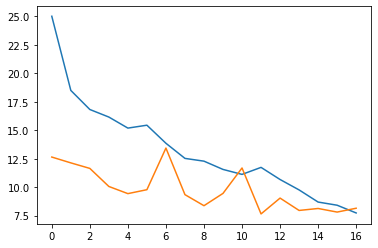

9/9 [==============================] - 3s 180ms/step
========== 2fold ==========
Epoch 1/100
44/44 [==============================] - 52s 1s/step - loss: 27.7288 - val_loss: 13.6766 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 47s 1s/step - loss: 20.9204 - val_loss: 10.5283 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 45s 1s/step - loss: 19.0571 - val_loss: 21.3533 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 45s 1s/step - loss: 27.5076 - val_loss: 11.4470 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 45s 1s/step - loss: 21.1484 - val_loss: 9.0319 - lr: 5.0000e-04
Epoch 6/100
44/44 [==============================] - 48s 1s/step - loss: 17.7259 - val_loss: 10.8985 - lr: 5.0000e-04
Epoch 7/100
44/44 [==============================] - 46s 1s/step - loss: 14.1815 - val_loss: 9.4180 - lr: 5.0000e-04
Epoch 8/100
44/44 [==============================] - 45s 1s/step - loss: 13.4022 - val_loss: 13.8784 - lr: 2.50

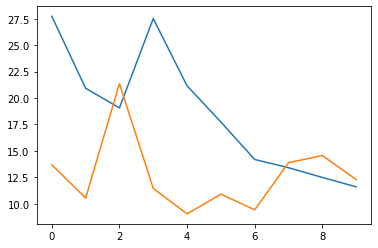

9/9 [==============================] - 3s 151ms/step
========== 3fold ==========
Epoch 1/100
44/44 [==============================] - 57s 1s/step - loss: 23.9054 - val_loss: 18.4642 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 46s 1s/step - loss: 20.5813 - val_loss: 22.2285 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 46s 1s/step - loss: 26.3424 - val_loss: 20.2875 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 46s 1s/step - loss: 25.0049 - val_loss: 18.5015 - lr: 5.0000e-04
Epoch 5/100
44/44 [==============================] - 46s 1s/step - loss: 27.1440 - val_loss: 19.6686 - lr: 5.0000e-04
Epoch 6/100
44/44 [==============================] - 49s 1s/step - loss: 23.5445 - val_loss: 16.5332 - lr: 2.5000e-04
Epoch 7/100
44/44 [==============================] - 47s 1s/step - loss: 22.2920 - val_loss: 15.2806 - lr: 2.5000e-04
Epoch 8/100
44/44 [==============================] - 46s 1s/step - loss: 21.8899 - val_loss: 15.7880 - lr

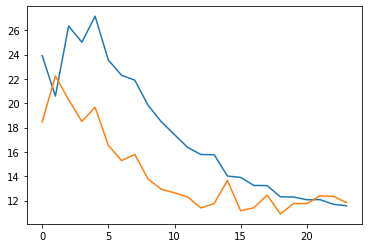

9/9 [==============================] - 3s 165ms/step
========== 4fold ==========
Epoch 1/100
44/44 [==============================] - 55s 1s/step - loss: 28.6164 - val_loss: 23.4835 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 46s 1s/step - loss: 27.9692 - val_loss: 20.1960 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 47s 1s/step - loss: 21.5496 - val_loss: 15.8379 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 48s 1s/step - loss: 18.3639 - val_loss: 16.3396 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 46s 1s/step - loss: 15.8303 - val_loss: 16.4891 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 46s 1s/step - loss: 13.2863 - val_loss: 16.7780 - lr: 5.0000e-04
Epoch 7/100
44/44 [==============================] - 46s 1s/step - loss: 12.6434 - val_loss: 17.7863 - lr: 5.0000e-04
Epoch 8/100
44/44 [==============================] - 48s 1s/step - loss: 11.9928 - val_loss: 16.5054 - lr: 2.5000

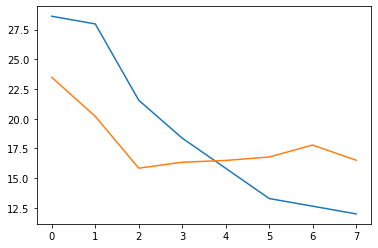

9/9 [==============================] - 3s 177ms/step
========== 5fold ==========
Epoch 1/100
44/44 [==============================] - 52s 1s/step - loss: 26.1068 - val_loss: 25.1224 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 45s 1s/step - loss: 23.3685 - val_loss: 24.5007 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 46s 1s/step - loss: 21.1680 - val_loss: 18.0936 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 47s 1s/step - loss: 21.4876 - val_loss: 15.9715 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 45s 1s/step - loss: 18.8584 - val_loss: 13.1235 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 45s 1s/step - loss: 19.9088 - val_loss: 27.1854 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 45s 1s/step - loss: 26.3995 - val_loss: 32.9059 - lr: 0.0010
Epoch 8/100
44/44 [==============================] - 44s 1s/step - loss: 27.1373 - val_loss: 21.6570 - lr: 5.0000e-04
Epo

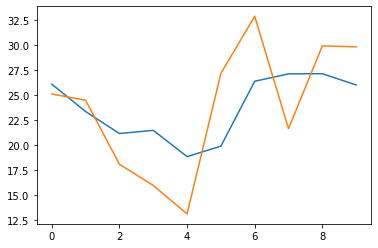

9/9 [==============================] - 3s 144ms/step
========== 6fold ==========
Epoch 1/100
44/44 [==============================] - 53s 1s/step - loss: 29.2755 - val_loss: 18.7123 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 45s 1s/step - loss: 27.8619 - val_loss: 12.8585 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 47s 1s/step - loss: 26.9081 - val_loss: 16.8006 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 45s 1s/step - loss: 28.4670 - val_loss: 16.1560 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 45s 1s/step - loss: 27.5881 - val_loss: 16.9254 - lr: 5.0000e-04
Epoch 6/100
44/44 [==============================] - 45s 1s/step - loss: 27.5254 - val_loss: 17.3446 - lr: 5.0000e-04
Epoch 7/100
44/44 [==============================] - 47s 1s/step - loss: 27.3102 - val_loss: 17.3919 - lr: 2.5000e-04


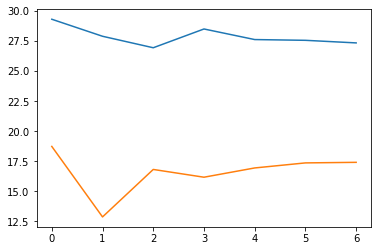

9/9 [==============================] - 3s 158ms/step
========== 7fold ==========
Epoch 1/100
44/44 [==============================] - 55s 1s/step - loss: 28.2090 - val_loss: 36.0471 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 48s 1s/step - loss: 27.4804 - val_loss: 35.3169 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 48s 1s/step - loss: 24.7956 - val_loss: 32.0342 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 48s 1s/step - loss: 22.5158 - val_loss: 32.4406 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 48s 1s/step - loss: 24.1201 - val_loss: 33.5388 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 49s 1s/step - loss: 24.2823 - val_loss: 33.8007 - lr: 5.0000e-04
Epoch 7/100
44/44 [==============================] - 48s 1s/step - loss: 23.9402 - val_loss: 33.9098 - lr: 5.0000e-04
Epoch 8/100
44/44 [==============================] - 48s 1s/step - loss: 23.4601 - val_loss: 35.6862 - lr: 2.5000

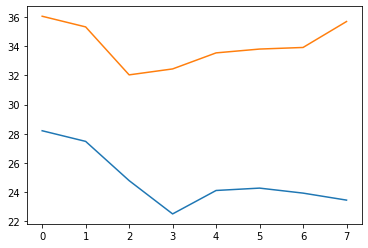

9/9 [==============================] - 3s 208ms/step
========== 8fold ==========
Epoch 1/100
44/44 [==============================] - 53s 1s/step - loss: 20.5714 - val_loss: 44.0474 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 45s 1s/step - loss: 20.1931 - val_loss: 55.8012 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 45s 1s/step - loss: 24.0191 - val_loss: 38.8189 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 44s 1s/step - loss: 16.7530 - val_loss: 43.4518 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 44s 1s/step - loss: 13.8369 - val_loss: 39.5674 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 45s 1s/step - loss: 12.5856 - val_loss: 39.2517 - lr: 5.0000e-04
Epoch 7/100
44/44 [==============================] - 44s 1s/step - loss: 11.9269 - val_loss: 35.3633 - lr: 5.0000e-04
Epoch 8/100
44/44 [==============================] - 44s 1s/step - loss: 11.7818 - val_loss: 41.4927 - lr: 5.0000

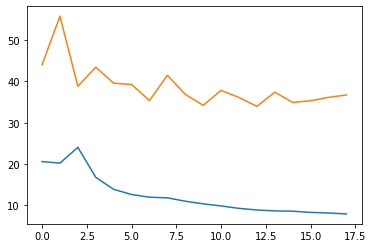

9/9 [==============================] - 3s 149ms/step
========== 9fold ==========
Epoch 1/100
46/46 [==============================] - 57s 1s/step - loss: 25.8361 - val_loss: 11.0052 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - 47s 1s/step - loss: 22.5172 - val_loss: 9.6717 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - 47s 1s/step - loss: 25.5880 - val_loss: 13.6374 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - 46s 1s/step - loss: 24.3763 - val_loss: 14.9857 - lr: 0.0010
Epoch 5/100
46/46 [==============================] - 46s 1s/step - loss: 17.8281 - val_loss: 12.8494 - lr: 5.0000e-04
Epoch 6/100
46/46 [==============================] - 49s 1s/step - loss: 19.0528 - val_loss: 8.4554 - lr: 5.0000e-04
Epoch 7/100
46/46 [==============================] - 46s 1s/step - loss: 17.3267 - val_loss: 5.8651 - lr: 5.0000e-04
Epoch 8/100
46/46 [==============================] - 46s 1s/step - loss: 15.3158 - val_loss: 12.6374 - lr: 5.000

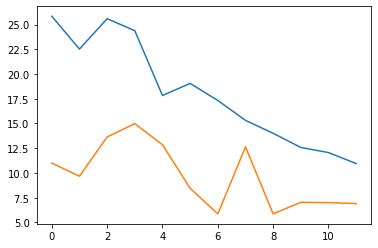

9/9 [==============================] - 3s 145ms/step
========== 10fold ==========
Epoch 1/100
46/46 [==============================] - 54s 1s/step - loss: 26.4737 - val_loss: 40.2018 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - 48s 1s/step - loss: 21.0184 - val_loss: 35.3797 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - 47s 1s/step - loss: 18.9090 - val_loss: 34.5682 - lr: 0.0010
Epoch 4/100
46/46 [==============================] - 47s 1s/step - loss: 18.1903 - val_loss: 30.2807 - lr: 0.0010
Epoch 5/100
46/46 [==============================] - 46s 1s/step - loss: 16.6385 - val_loss: 23.0609 - lr: 0.0010
Epoch 6/100
46/46 [==============================] - 49s 1s/step - loss: 16.5965 - val_loss: 29.2452 - lr: 0.0010
Epoch 7/100
46/46 [==============================] - 46s 1s/step - loss: 16.4838 - val_loss: 26.0932 - lr: 0.0010
Epoch 8/100
46/46 [==============================] - 47s 1s/step - loss: 16.0431 - val_loss: 28.3139 - lr: 5.0000e-04
Ep

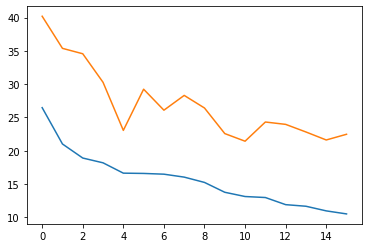

9/9 [==============================] - 3s 159ms/step


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
pre_all = np.zeros((140,1))
for i, (train, val) in enumerate(kfold.split(train_li, train_ta_li)):
    print('='*10, f'{i+1}fold', '='*10)
    model = make_model()
    train_li_fold = []
    val_li_fold = []
    train_ta_li_fold = []
    val_ta_li_fold = []
    for train_index in train:
        train_li_fold.append(train_li[train_index])
        train_ta_li_fold.append(train_ta_li[train_index])
    for val_index in val:
        val_li_fold.append(train_li[val_index])
        val_ta_li_fold.append(train_ta_li[val_index])

    train_dr = data_loder(train_li_fold, train_ta_li_fold, batch_size=16, shuffle=True, test=False)
    val_dr = data_loder(val_li_fold, val_ta_li_fold, batch_size=16, shuffle=False, test=False)
    test_dr = data_loder(test_li, test_ta_li, batch_size=16, shuffle=False, test=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError())
    eary_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    lr_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)

    his = model.fit(train_dr, epochs=100, validation_data=val_dr, callbacks=[eary_stop, lr_rate], batch_size=16)

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.show()

    pre = model.predict(test_dr)
    pre_all += pre/10


In [ ]:
pre_all

array([[ 2.2711563 ],
       [ 5.03586781],
       [ 5.13825335],
       [ 5.31019117],
       [ 5.56701899],
       [ 6.16477492],
       [ 6.51516518],
       [ 7.26875867],
       [ 8.02832791],
       [ 8.65931675],
       [ 9.46712762],
       [11.28767586],
       [15.75433499],
       [16.14706433],
       [20.85794604],
       [22.65719521],
       [23.63491815],
       [24.5945816 ],
       [28.40164065],
       [28.42956424],
       [41.00350213],
       [49.33697295],
       [55.24247122],
       [53.97044086],
       [58.89740753],
       [65.39028287],
       [69.29595542],
       [67.47841048],
       [ 1.8442617 ],
       [ 2.10965355],
       [ 2.15159821],
       [ 2.99014849],
       [ 4.8747881 ],
       [ 5.59553598],
       [ 5.60514978],
       [ 5.95307821],
       [ 6.7470257 ],
       [ 7.33215228],
       [10.09555125],
       [11.34703228],
       [12.29090106],
       [17.72311175],
       [19.74172038],
       [25.20012981],
       [29.5670554 ],
       [29

# sub

In [ ]:
!unzip '/content/sample_submission.zip'

Archive:  /content/sample_submission.zip
  inflating: TEST_01.csv             
  inflating: TEST_02.csv             
  inflating: TEST_03.csv             
  inflating: TEST_04.csv             
  inflating: TEST_05.csv             


In [ ]:
test_01 = pd.read_csv('/content/TEST_01.csv')
test_01['predicted_weight_g'] = pre[:28]
test_01.to_csv('/content/TEST_01.csv', index=False)
test_02 = pd.read_csv('/content/TEST_02.csv')
test_02['predicted_weight_g'] = pre[28:56]
test_02.to_csv('/content/TEST_02.csv', index=False)
test_03 = pd.read_csv('/content/TEST_03.csv')
test_03['predicted_weight_g'] = pre[56:84]
test_03.to_csv('/content/TEST_03.csv', index=False)
test_04 = pd.read_csv('/content/TEST_04.csv')
test_04['predicted_weight_g'] = pre[84:112]
test_04.to_csv('/content/TEST_04.csv', index=False)
test_05 = pd.read_csv('/content/TEST_05.csv')
test_05['predicted_weight_g'] = pre[112:]
test_05.to_csv('/content/TEST_05.csv', index=False)

In [ ]:
test_01 = pd.read_csv('/content/TEST_01.csv')
test_01['predicted_weight_g'] = pre_all[:28]
test_01.to_csv('/content/TEST_01.csv', index=False)
test_02 = pd.read_csv('/content/TEST_02.csv')
test_02['predicted_weight_g'] = pre_all[28:56]
test_02.to_csv('/content/TEST_02.csv', index=False)
test_03 = pd.read_csv('/content/TEST_03.csv')
test_03['predicted_weight_g'] = pre_all[56:84]
test_03.to_csv('/content/TEST_03.csv', index=False)
test_04 = pd.read_csv('/content/TEST_04.csv')
test_04['predicted_weight_g'] = pre_all[84:112]
test_04.to_csv('/content/TEST_04.csv', index=False)
test_05 = pd.read_csv('/content/TEST_05.csv')
test_05['predicted_weight_g'] = pre_all[112:]
test_05.to_csv('/content/TEST_05.csv', index=False)